<a href="https://colab.research.google.com/github/mathocosta/TCC/blob/master/TCC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Clusterização com o K-Means


## Configuração Inicial
Abaixo estão as configurações feitas para ter acesso aos arquivos no Drive. Será solicitado um código de autorização antes de ter acesso.

In [1]:
import os
from google.colab import drive

# Prepara os arquivos do drive
drive.mount('/content/drive')

# Caminho para os arquivos da análise
base_folder = '/content/drive/My Drive/TCC/'


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


## Carregando modelo do GloVe
Abaixo é carregado o modelo de embeddings a partir do arquivo do GloVe baixado e salvo na pasta do Drive. O método retorna um dicionário onde as chaves são as palavras e os valores são as representações dessas palavras.

In [108]:
import numpy as np

def load_GloVe_model(glove_file):
    print("Carregando modelo do GloVe...")
    
    with open(glove_file, encoding = "utf8") as f:
        content = f.readlines()
      
    model = {}
    for line in content:
        split_line = line.split(" ")
        word = split_line[0]
        embedding = np.array([float(val) for val in split_line[1:]])
        model[word] = embedding
  
    print("Finalizado.",len(model)," palavras carregadas")
  
    return model

glove_filename = os.path.join(base_folder, 'glove_embeddings/glove_s50.txt')
glove_model = load_GloVe_model(glove_filename)


Carregando modelo do GloVe...
Finalizado. 929606  palavras carregadas


## Carregando os textos

In [109]:
def texts_from_folder(data_path):
    print("Carregando textos para análise...")
    texts = []
    for r, d, f in os.walk(data_path):
        for file in f:
            if '.txt' in file:
                text = open(os.path.join(r, file)).read()
                texts.append(text)

    return texts

samples_folder_path = os.path.join(base_folder, '300_textos')
sample_texts = texts_from_folder(samples_folder_path)

print("{} textos carregados".format(len(sample_texts)))


Carregando textos para análise...
300 textos carregados


## Processamento dos textos
Abaixo ocorre o processamento dos textos. Cada etapa está explicada separadamente.


### Pré-processamento
Antes dos outros procedimentos é feito um pré-processamento nas palavras para remover os caracteres especiais e deixar todas os caracteres em minúsculo.

In [79]:
import nltk
from nltk.corpus import stopwords
from string import punctuation

# Pacotes para serem carregados:
nltk.download('averaged_perceptron_tagger')
nltk.download('floresta')
nltk.download('mac_morpho')
nltk.download('machado')
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('words')

stopwords_and_punctuation = set(stopwords.words('portuguese') + list(punctuation))

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package floresta to /root/nltk_data...
[nltk_data]   Package floresta is already up-to-date!
[nltk_data] Downloading package mac_morpho to /root/nltk_data...
[nltk_data]   Package mac_morpho is already up-to-date!
[nltk_data] Downloading package machado to /root/nltk_data...
[nltk_data]   Package machado is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!


In [0]:
from nltk.tokenize import word_tokenize

def prepare(text):
    words = []
    for word in word_tokenize(text):
        word = word.lower()
        empty_word = not word
        if not empty_word:
            words.append(word)

    return ' '.join(words)

processed_texts = [prepare(text) for text in sample_texts]


### Criação do vocabulário com o TFIDF

É criado um vocabulário de palavras mais importantes nos textos utilizando a técnica TFIDF, esse passo tem como objetivo remover as *stop words*, que são palavras inúteis para a análise. Isso também faz com que menos palavras sejam convertidas para suas representações vetoriais, otimizando o sistema.

In [0]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

def sorted_coo(coo_matrix):
    tuples = zip(coo_matrix.col, coo_matrix.data)
    return sorted(tuples, key=lambda x: (x[1], x[0]), reverse=True)

def extract_topn_from_vector(feature_names, sorted_items, topn = 5000):
    # Restringe os índices aos top-n itens do vetor
    if len(sorted_items) > topn:
        sorted_items = sorted_items[:topn]
    
    # Seleciona somente as palavras
    topn_words = []
    for index, _ in sorted_items:
        feature_value = feature_names[index]
        topn_words.append(feature_value)

    return topn_words

count_vectorizer = CountVectorizer(
    max_df = 0.3,
    analyzer = 'word', 
    max_features = 10000, 
    stop_words = stopwords_and_punctuation
)
word_count_vector = count_vectorizer.fit_transform(processed_texts)
tfidf_transformer = TfidfTransformer(smooth_idf = True, use_idf = True)
tfidf_transformer.fit(word_count_vector)

topn_words_from_texts = []
for text in processed_texts:
    tfidf_vector = tfidf_transformer.transform(count_vectorizer.transform([text]))
    topn_words_from_texts.append(extract_topn_from_vector(
        count_vectorizer.get_feature_names(), sorted_coo(tfidf_vector.tocoo())
    ))

### Representação vetorial dos textos

Nessa etapa, o objetivo é obter uma representação vetorial de uma sentença de palavras, no caso, do texto completo. Por isso, é obtida a representação de cada palavra individualmente e adicionada a um vetor único para representar o texto por completo. Depois, é feita a normalização de todas representações dos textos.

In [1]:
# Transforma as palavras nas representações vetoriais e concatena
# os vetores para formar um resultante que representa o texto
def vectorize_words(text_words, model):
    text_vector = []
    for word in text_words:
        try:
            text_vector = np.hstack((text_vector, model[word]))

        # Erro de quando uma key não está presente no modelo
        except (KeyError):
            continue
            
    return text_vector

# Normaliza um conjunto de vetores de todos os textos. Se baseia no maior de 
# todos para que todos tenham a mesma quantidade de elementos
def pad(matrix):
    max_value = np.amax([vector.size for vector in matrix])
    X_pad = []
    for vector in matrix:
        X_pad.append(np.pad(vector, (0, max_value - vector.size), 'constant'))
    return X_pad

X = []
for text in topn_words_from_texts:
    # Precisa dessa verificação pois alguns textos vieram vazios
    textIsEmpty = not text
    if not textIsEmpty:
        text_vector = vectorize_words(text_words, glove_model)
        X.append(text_vector)

X = pad(X)

NameError: ignored

## Clusterização

### Execução do K-Means

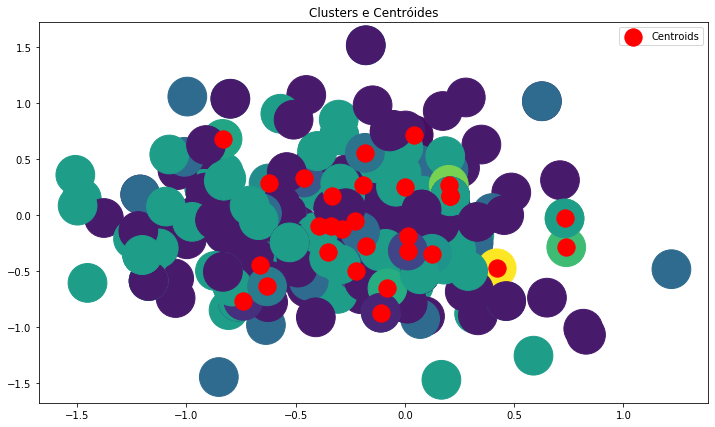

In [124]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters = 30, init = 'k-means++')
kmeans.fit(X)

XArray = np.asarray(X)
plt.rcParams['figure.figsize'] = (12, 7) 
plt.scatter(XArray[:, 0], XArray[:, 1], s = 1500, c = kmeans.labels_)
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s = 300, c = 'red', label = 'Centroids')
plt.title('Clusters e Centróides')
plt.legend()
plt.show()


### Elbow Method

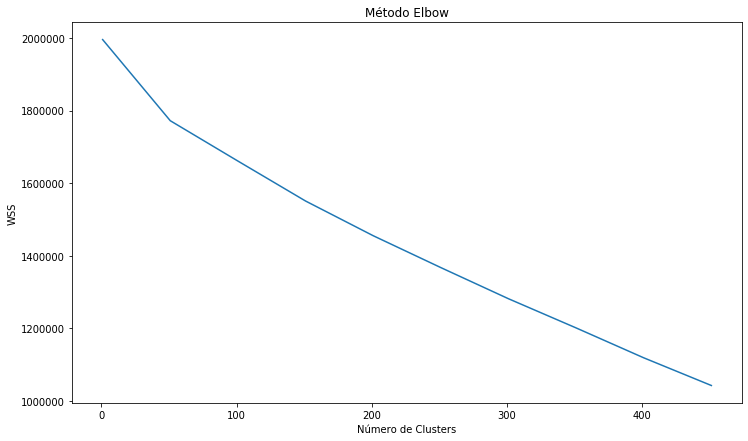

In [0]:
import matplotlib.pyplot as plt

wcss = []
elbowRange = range(1, 500, 50)

for i in elbowRange:
    kmeans = KMeans(n_clusters = i, init = 'k-means++')
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)

plt.rcParams['figure.figsize'] = (12, 7) 
plt.plot(elbowRange, wcss)
plt.title('Método Elbow')
plt.xlabel('Número de Clusters')
plt.ylabel('WSS') #within cluster sum of squares
plt.show()
